In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# load data
df_resampled = pd.read_pickle("./data_for_modeling.pickle")

In [3]:
df_resampled_minute = df_resampled.resample("min").nearest()
df_resampled_hour = df_resampled.resample("H").nearest()

In [4]:
df_resampled_hour['tp'] = df_resampled_hour['tp'] * 3600
df_resampled_minute['tp'] = df_resampled_minute['tp'] * 3600

In [5]:
df_resampled_minute = df_resampled_minute[df_resampled_minute['tp'] < (0.01 / 1000) / 60]
df_resampled_hour = df_resampled_hour[df_resampled_hour['tp'] < (0.01 / 1000)]
df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 3600]

In [6]:
df_copy = df_resampled_minute

In [7]:
#df_copy = df_resampled.copy()
# 飛沫データのラベリング
spray_all = np.array(df_copy['SPC_flux[mm]'])
# 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
spc_label = [1 if i > 0.0 else 0 for i in spray_all]
df_copy['label'] = spc_label

In [8]:
print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)

4371 147 3.363074811256005


# 普通にlightgbm

In [22]:
X = df_copy.loc[:, [i for i in df_copy.columns if i != 'SPC_flux[mm]' and i != 'label']]
print(X.columns)
y = df_copy.loc[:, "label"]

Index([                     'ピッチ (度)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                        'Course[deg]',                  'Speed[knot]',
                                'mwp',                          't2m',
                                'sst',                          'mwd',
                                 'tp',                          'swh',
                                'u10',                          'v10',
                    'relative_wind_y',                              1,
                                    2,                              3,
                                    4,                              5,
                                    6,                              7,
                                    8,                              9,
                                   10,                             11,
                                   12,                             13,
      

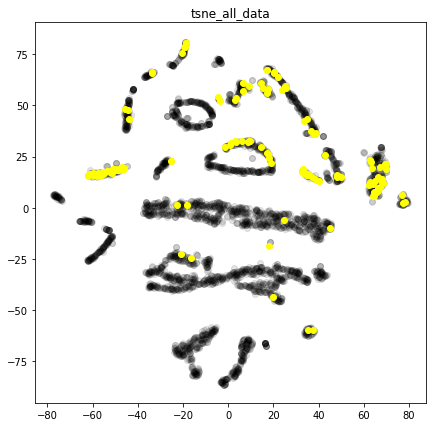

<Figure size 432x288 with 0 Axes>

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=1,
                                     file_path='/home/nt/Desktop/soturon'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        tsne = TSNE(n_components=2, random_state=random_state)
        transformed = tsne.fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title(image_name)
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))


plot_reduced_graph(X, y, 'tsne_all_data', model='tsne', random_sampling=False)

In [64]:
all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

#for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
for_modeling = all_columns
for_modeling.remove('tp')
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
label = np.array(df_copy['label'])

['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Course[deg]', 'Speed[knot]', 'mwp', 't2m', 'sst', 'mwd', 'swh', 'u10', 'v10', 'relative_wind_y', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 'Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio']


In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/home/nt/Desktop/soturon'):
#     if random_sampling:
#         data = data.sample(1000, random_state=random_state)
#         label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    #label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    elif model == 'isomap':
        transformed = Isomap(n_components=2, random_state=random_state).fit_transform(data)
        
    return transformed

transformed = plot_reduced_graph(X, y, 'tsne_all_data', model='tsne', random_sampling=False)

In [90]:
all_columns

['ピッチ (度)',
 'Relative wind speed[m/s]',
 '相対風速 (m/s)_cos',
 '相対風速 (m/s)_sin',
 'Course[deg]',
 'Speed[knot]',
 'mwp',
 't2m',
 'sst',
 'mwd',
 'swh',
 'u10',
 'v10',
 'relative_wind_y',
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 'Relative_wind_direction[deg]',
 'Relative wave direction[deg]',
 'Speed[m/s]',
 'encounter cycle',
 'wave_length',
 'ratio']

(array([ 579., 1620.,  240.,  720.,  132.,  120.,  300.,  300.,  300.,
          60.]), array([ 85.7731887 ,  96.80073996, 107.82829121, 118.85584247,
        129.88339373, 140.91094499, 151.93849625, 162.9660475 ,
        173.99359876, 185.02115002, 196.04870128]), <a list of 10 Patch objects>)

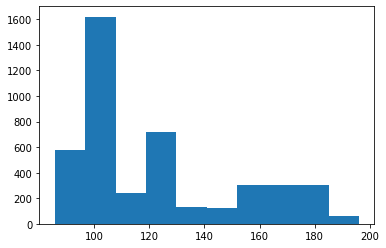

In [91]:
plt.hist(df_copy['wave_length'])

[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]


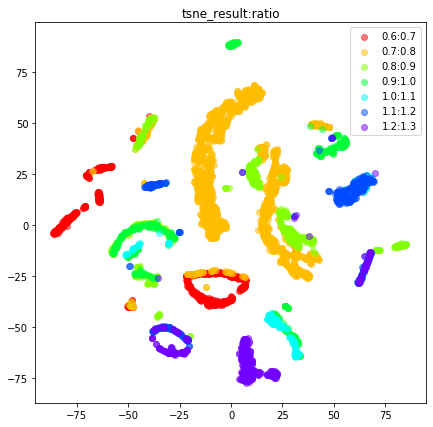

<Figure size 432x288 with 0 Axes>

In [88]:
import matplotlib.cm as cm

for_label = "label"
label = df_copy.loc[:, for_label]
kaikyuti = [i/10 for i in range(6, 14, 1)]
print(kaikyuti)
#kaikyuti = [-100, 0, 0.28, 10000]

plt.figure(figsize=(7, 7))
for i in range(0, len(kaikyuti)-1):
    start = kaikyuti[i]
    end = kaikyuti[i+1]
    transformed_kaikyu = transformed[(label > start) & (label <= end)]
    plt.scatter(transformed_kaikyu[:, 0], transformed_kaikyu[:, 1], color=cm.hsv(i/len(kaikyuti)),
                label="{}:{}".format(start, end), alpha=0.5)
plt.legend()
plt.title("tsne_result:{}".format(for_label))
plt.show()
plt.savefig("tsne_result:{}".format(for_label))

[0, 1]


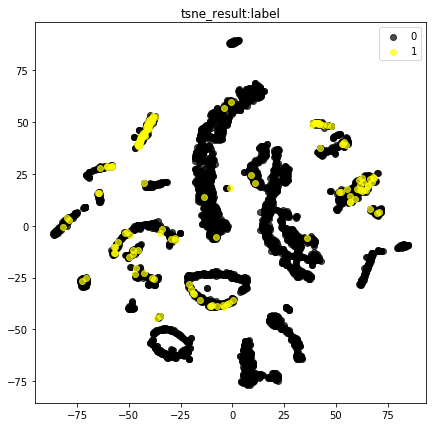

<Figure size 432x288 with 0 Axes>

In [118]:
import matplotlib.cm as cm

for_label = "label"
label = df_copy.loc[:, for_label]
kaikyuti = [0, 1]
color_ = ["black", "yellow"]
print(kaikyuti)
#kaikyuti = [-100, 0, 0.28, 10000]

plt.figure(figsize=(7, 7))
for i in range(len(kaikyuti)):
    start = kaikyuti[i]
    transformed_kaikyu = transformed[label==start]
    plt.scatter(transformed_kaikyu[:, 0], transformed_kaikyu[:, 1], color=color_[i],
                label="{}".format(start), alpha=0.7)
plt.legend()
plt.title("tsne_result:{}".format(for_label))
plt.show()
plt.savefig("tsne_result:{}".format(for_label))

In [94]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from imblearn.over_sampling import SMOTE

# SMOTE to balance dataset
sm = SMOTE()
X, y = sm.fit_sample(X, y)

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test
    
def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

print(len(y_train), len(y_test), len(y_train2), len(y_valid))

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
84
6758 1690 5406 1352


In [95]:
lgbm_params = {
    'learning_rate': 0.01,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

[1]	valid_0's binary_logloss: 0.688145
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.683241
[3]	valid_0's binary_logloss: 0.678432
[4]	valid_0's binary_logloss: 0.673718
[5]	valid_0's binary_logloss: 0.669081
[6]	valid_0's binary_logloss: 0.664544
[7]	valid_0's binary_logloss: 0.660095
[8]	valid_0's binary_logloss: 0.655717
[9]	valid_0's binary_logloss: 0.651363
[10]	valid_0's binary_logloss: 0.647094
[11]	valid_0's binary_logloss: 0.642902
[12]	valid_0's binary_logloss: 0.638839
[13]	valid_0's binary_logloss: 0.634795
[14]	valid_0's binary_logloss: 0.630698
[15]	valid_0's binary_logloss: 0.626805
[16]	valid_0's binary_logloss: 0.62288
[17]	valid_0's binary_logloss: 0.618996
[18]	valid_0's binary_logloss: 0.615185
[19]	valid_0's binary_logloss: 0.611556
[20]	valid_0's binary_logloss: 0.607927
[21]	valid_0's binary_logloss: 0.604312
[22]	valid_0's binary_logloss: 0.600875
[23]	valid_0's binary_logloss: 0.597431
[24]	valid_0's binary_logloss

[226]	valid_0's binary_logloss: 0.354049
[227]	valid_0's binary_logloss: 0.353659
[228]	valid_0's binary_logloss: 0.353199
[229]	valid_0's binary_logloss: 0.352739
[230]	valid_0's binary_logloss: 0.352365
[231]	valid_0's binary_logloss: 0.3519
[232]	valid_0's binary_logloss: 0.351503
[233]	valid_0's binary_logloss: 0.351194
[234]	valid_0's binary_logloss: 0.35076
[235]	valid_0's binary_logloss: 0.350394
[236]	valid_0's binary_logloss: 0.350051
[237]	valid_0's binary_logloss: 0.349703
[238]	valid_0's binary_logloss: 0.3494
[239]	valid_0's binary_logloss: 0.348971
[240]	valid_0's binary_logloss: 0.348668
[241]	valid_0's binary_logloss: 0.348266
[242]	valid_0's binary_logloss: 0.347871
[243]	valid_0's binary_logloss: 0.347452
[244]	valid_0's binary_logloss: 0.347087
[245]	valid_0's binary_logloss: 0.346818
[246]	valid_0's binary_logloss: 0.346456
[247]	valid_0's binary_logloss: 0.346054
[248]	valid_0's binary_logloss: 0.345769
[249]	valid_0's binary_logloss: 0.345368
[250]	valid_0's binar

[617]	valid_0's binary_logloss: 0.268367
[618]	valid_0's binary_logloss: 0.268242
[619]	valid_0's binary_logloss: 0.268053
[620]	valid_0's binary_logloss: 0.267944
[621]	valid_0's binary_logloss: 0.267793
[622]	valid_0's binary_logloss: 0.267671
[623]	valid_0's binary_logloss: 0.26753
[624]	valid_0's binary_logloss: 0.267327
[625]	valid_0's binary_logloss: 0.267103
[626]	valid_0's binary_logloss: 0.267001
[627]	valid_0's binary_logloss: 0.266785
[628]	valid_0's binary_logloss: 0.266665
[629]	valid_0's binary_logloss: 0.266488
[630]	valid_0's binary_logloss: 0.266331
[631]	valid_0's binary_logloss: 0.266192
[632]	valid_0's binary_logloss: 0.266042
[633]	valid_0's binary_logloss: 0.26597
[634]	valid_0's binary_logloss: 0.265752
[635]	valid_0's binary_logloss: 0.265645
[636]	valid_0's binary_logloss: 0.26551
[637]	valid_0's binary_logloss: 0.265347
[638]	valid_0's binary_logloss: 0.265211
[639]	valid_0's binary_logloss: 0.265125
[640]	valid_0's binary_logloss: 0.265009
[641]	valid_0's bin

[886]	valid_0's binary_logloss: 0.236432
[887]	valid_0's binary_logloss: 0.23629
[888]	valid_0's binary_logloss: 0.236201
[889]	valid_0's binary_logloss: 0.236068
[890]	valid_0's binary_logloss: 0.236012
[891]	valid_0's binary_logloss: 0.235958
[892]	valid_0's binary_logloss: 0.235815
[893]	valid_0's binary_logloss: 0.235736
[894]	valid_0's binary_logloss: 0.235597
[895]	valid_0's binary_logloss: 0.235451
[896]	valid_0's binary_logloss: 0.235322
[897]	valid_0's binary_logloss: 0.235222
[898]	valid_0's binary_logloss: 0.235167
[899]	valid_0's binary_logloss: 0.235145
[900]	valid_0's binary_logloss: 0.235006
[901]	valid_0's binary_logloss: 0.23488
[902]	valid_0's binary_logloss: 0.234711
[903]	valid_0's binary_logloss: 0.234624
[904]	valid_0's binary_logloss: 0.234542
[905]	valid_0's binary_logloss: 0.234473
[906]	valid_0's binary_logloss: 0.234331
[907]	valid_0's binary_logloss: 0.234235
[908]	valid_0's binary_logloss: 0.234088
[909]	valid_0's binary_logloss: 0.23404
[910]	valid_0's bin

# KFoldではない

In [98]:
df_copy.columns

Index([                     'ピッチ (度)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
                                'swh',                          'u10',
                                'v10',                        'label',
                    'relative_wind_y',                              1,
                                    2,                              3,
                                    4,                              5,
                                    6,                              7,
                                    8,                              9,
                                   10,                             11,
      

In [115]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['ratio', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = ['swh']
#for_modeling = all_columns
for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)

X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from imblearn.over_sampling import SMOTE

# SMOTE to balance dataset
sm = SMOTE()
X, y = sm.fit_sample(X, y)
print(len(y), len(y[y==1]))

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

# def imbalanced_data_split(X, y, seed, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
#     for train_index, test_index in sss.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         return X_train, X_test, y_train, y_test

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model
    
def imbalanced_data_split_(X, y, seed1, seed2, test_size=0.2):
    sss = StratifiedKFold(n_splits=5, random_state=seed1)
    cms = []
    f_score = []
    recall = []
    precision = []
    accuracy = []
    for train_index, test_index in tqdm(sss.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(len(X_train), len(X_test))
        print(len(y_train[y_train==1])/len(y_train))
        
        X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed2, test_size=0.2)
        model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

        y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
        y_pred_binary = []
        for p in y_pred:
            if p >= 0.2:
                y_pred_binary.append(1)
            else:
                y_pred_binary.append(0)

        from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
        cm = confusion_matrix(y_test, y_pred_binary)
        print(cm)
        cms.append(cm)
        accuracy.append(accuracy_score(y_pred_binary, y_test))
        recall.append(recall_score(y_pred_binary, y_test))
        precision.append(precision_score(y_pred_binary, y_test))
        f_score.append(f1_score(y_pred_binary, y_test))
        
    return cms, accuracy, recall, precision, f_score
            
    
date = datetime.now()
seed2 = date.minute + date.second + date.hour

cms, accuracy, recall, precision, f_score = imbalanced_data_split_(X, y, seed1, seed2)

/home/nt/Desktop/soturon/soturon/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
0it [00:00, ?it/s]

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
8448 4224
52
6758 1690
0.5
[1]	valid_0's binary_logloss: 0.633929
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.582215
[3]	valid_0's binary_logloss: 0.539495
[4]	valid_0's binary_logloss: 0.504324
[5]	valid_0's binary_logloss: 0.473276
[6]	valid_0's binary_logloss: 0.446947
[7]	valid_0's binary_logloss: 0.424588
[8]	valid_0's binary_logloss: 0.403558
[9]	valid_0's binary_logloss: 0.385801
[10]	valid_0's binary_logloss: 0.370752
[11]	valid_0's binary_logloss: 0.350439
[12]	valid_0's binary_logloss: 0.337856
[13]	valid_0's binary_logloss: 0.321788
[14]	valid_0's binary_logloss: 0.311773
[15]	valid_0's binary_logloss: 0.298837
[16]	valid_0's binary_logloss: 0.287387
[17]	valid_0's binary_logloss: 0.276966
[18]	valid_0's binary_logloss: 0.268126
[19]	valid_0's binar

1it [00:00,  1.68it/s]


[343]	valid_0's binary_logloss: 0.0513656
[344]	valid_0's binary_logloss: 0.0513304
[345]	valid_0's binary_logloss: 0.0513151
[346]	valid_0's binary_logloss: 0.0514298
[347]	valid_0's binary_logloss: 0.0514107
[348]	valid_0's binary_logloss: 0.0513387
[349]	valid_0's binary_logloss: 0.0512645
[350]	valid_0's binary_logloss: 0.0512153
[351]	valid_0's binary_logloss: 0.0511068
[352]	valid_0's binary_logloss: 0.0510228
[353]	valid_0's binary_logloss: 0.0509229
[354]	valid_0's binary_logloss: 0.0507028
[355]	valid_0's binary_logloss: 0.0507856
[356]	valid_0's binary_logloss: 0.0508126
[357]	valid_0's binary_logloss: 0.0507152
[358]	valid_0's binary_logloss: 0.0507134
[359]	valid_0's binary_logloss: 0.0506832
[360]	valid_0's binary_logloss: 0.0506046
[361]	valid_0's binary_logloss: 0.0504906
[362]	valid_0's binary_logloss: 0.0504574
[363]	valid_0's binary_logloss: 0.0503185
[364]	valid_0's binary_logloss: 0.0503263
[365]	valid_0's binary_logloss: 0.050236
[366]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.64694
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.610211
[3]	valid_0's binary_logloss: 0.578314
[4]	valid_0's binary_logloss: 0.552053
[5]	valid_0's binary_logloss: 0.529736
[6]	valid_0's binary_logloss: 0.509922
[7]	valid_0's binary_logloss: 0.493934
[8]	valid_0's binary_logloss: 0.479854
[9]	valid_0's binary_logloss: 0.468009
[10]	valid_0's binary_logloss: 0.45602
[11]	valid_0's binary_logloss: 0.4448
[12]	valid_0's binary_logloss: 0.436115
[13]	valid_0's binary_logloss: 0.428018
[14]	valid_0's binary_logloss: 0.419882
[15]	valid_0's binary_logloss: 0.411966
[16]	valid_0's binary_logloss: 0.404022
[17]	valid_0's binary_logloss: 0.39937
[18]	valid_0's binary_logloss: 0.392834
[19]	valid_0's binary_logloss: 0.38688
[20]	valid_0's binary_logloss: 0.380522
[21]	valid_0's binary_logloss: 0.376813
[22]	valid_0's binary_logloss: 0.372528
[23]	valid_0's binary_logloss: 0.366731
[24]	valid_0's binary_logloss: 0.3

[223]	valid_0's binary_logloss: 0.160152
[224]	valid_0's binary_logloss: 0.15986
[225]	valid_0's binary_logloss: 0.159585
[226]	valid_0's binary_logloss: 0.159415
[227]	valid_0's binary_logloss: 0.158895
[228]	valid_0's binary_logloss: 0.158187
[229]	valid_0's binary_logloss: 0.157843
[230]	valid_0's binary_logloss: 0.157811
[231]	valid_0's binary_logloss: 0.157715
[232]	valid_0's binary_logloss: 0.156851
[233]	valid_0's binary_logloss: 0.156494
[234]	valid_0's binary_logloss: 0.155675
[235]	valid_0's binary_logloss: 0.155137
[236]	valid_0's binary_logloss: 0.154836
[237]	valid_0's binary_logloss: 0.154763
[238]	valid_0's binary_logloss: 0.15401
[239]	valid_0's binary_logloss: 0.153665
[240]	valid_0's binary_logloss: 0.153527
[241]	valid_0's binary_logloss: 0.153352
[242]	valid_0's binary_logloss: 0.152838
[243]	valid_0's binary_logloss: 0.152629
[244]	valid_0's binary_logloss: 0.152217
[245]	valid_0's binary_logloss: 0.152017
[246]	valid_0's binary_logloss: 0.151519
[247]	valid_0's bi

[510]	valid_0's binary_logloss: 0.109245
[511]	valid_0's binary_logloss: 0.109205
[512]	valid_0's binary_logloss: 0.109124
[513]	valid_0's binary_logloss: 0.10908
[514]	valid_0's binary_logloss: 0.108959
[515]	valid_0's binary_logloss: 0.108795
[516]	valid_0's binary_logloss: 0.108843
[517]	valid_0's binary_logloss: 0.108814
[518]	valid_0's binary_logloss: 0.108679
[519]	valid_0's binary_logloss: 0.10848
[520]	valid_0's binary_logloss: 0.108263
[521]	valid_0's binary_logloss: 0.108172
[522]	valid_0's binary_logloss: 0.108062
[523]	valid_0's binary_logloss: 0.108061
[524]	valid_0's binary_logloss: 0.107909
[525]	valid_0's binary_logloss: 0.107853
[526]	valid_0's binary_logloss: 0.107769
[527]	valid_0's binary_logloss: 0.107882
[528]	valid_0's binary_logloss: 0.107911
[529]	valid_0's binary_logloss: 0.107807
[530]	valid_0's binary_logloss: 0.107575
[531]	valid_0's binary_logloss: 0.107477
[532]	valid_0's binary_logloss: 0.107388
[533]	valid_0's binary_logloss: 0.107301
[534]	valid_0's bi

2it [00:01,  1.50it/s]

[776]	valid_0's binary_logloss: 0.0954651
[777]	valid_0's binary_logloss: 0.0954533
[778]	valid_0's binary_logloss: 0.0952842
[779]	valid_0's binary_logloss: 0.0951822
[780]	valid_0's binary_logloss: 0.0950261
[781]	valid_0's binary_logloss: 0.0949691
[782]	valid_0's binary_logloss: 0.0948041
[783]	valid_0's binary_logloss: 0.0947777
[784]	valid_0's binary_logloss: 0.0947595
[785]	valid_0's binary_logloss: 0.0946516
[786]	valid_0's binary_logloss: 0.0946087
[787]	valid_0's binary_logloss: 0.094595
[788]	valid_0's binary_logloss: 0.0945856
[789]	valid_0's binary_logloss: 0.0946166
[790]	valid_0's binary_logloss: 0.094566
[791]	valid_0's binary_logloss: 0.0944694
[792]	valid_0's binary_logloss: 0.0943726
[793]	valid_0's binary_logloss: 0.0943182
[794]	valid_0's binary_logloss: 0.0942551
[795]	valid_0's binary_logloss: 0.0942489
[796]	valid_0's binary_logloss: 0.0941006
[797]	valid_0's binary_logloss: 0.0940723
[798]	valid_0's binary_logloss: 0.0940393
[799]	valid_0's binary_logloss: 0.09

[1]	valid_0's binary_logloss: 0.645075
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.607053
[3]	valid_0's binary_logloss: 0.573713
[4]	valid_0's binary_logloss: 0.546105
[5]	valid_0's binary_logloss: 0.521859
[6]	valid_0's binary_logloss: 0.499815
[7]	valid_0's binary_logloss: 0.482203
[8]	valid_0's binary_logloss: 0.465903
[9]	valid_0's binary_logloss: 0.450353
[10]	valid_0's binary_logloss: 0.438728
[11]	valid_0's binary_logloss: 0.426431
[12]	valid_0's binary_logloss: 0.415469
[13]	valid_0's binary_logloss: 0.404965
[14]	valid_0's binary_logloss: 0.396418
[15]	valid_0's binary_logloss: 0.388416
[16]	valid_0's binary_logloss: 0.382162
[17]	valid_0's binary_logloss: 0.375449
[18]	valid_0's binary_logloss: 0.36931
[19]	valid_0's binary_logloss: 0.364042
[20]	valid_0's binary_logloss: 0.35963
[21]	valid_0's binary_logloss: 0.355957
[22]	valid_0's binary_logloss: 0.350643
[23]	valid_0's binary_logloss: 0.345453
[24]	valid_0's binary_logloss:

[234]	valid_0's binary_logloss: 0.157372
[235]	valid_0's binary_logloss: 0.15694
[236]	valid_0's binary_logloss: 0.15689
[237]	valid_0's binary_logloss: 0.156641
[238]	valid_0's binary_logloss: 0.156476
[239]	valid_0's binary_logloss: 0.156339
[240]	valid_0's binary_logloss: 0.1562
[241]	valid_0's binary_logloss: 0.156045
[242]	valid_0's binary_logloss: 0.155558
[243]	valid_0's binary_logloss: 0.155229
[244]	valid_0's binary_logloss: 0.154943
[245]	valid_0's binary_logloss: 0.154488
[246]	valid_0's binary_logloss: 0.153917
[247]	valid_0's binary_logloss: 0.153887
[248]	valid_0's binary_logloss: 0.153728
[249]	valid_0's binary_logloss: 0.153376
[250]	valid_0's binary_logloss: 0.153001
[251]	valid_0's binary_logloss: 0.152857
[252]	valid_0's binary_logloss: 0.152547
[253]	valid_0's binary_logloss: 0.152346
[254]	valid_0's binary_logloss: 0.152021
[255]	valid_0's binary_logloss: 0.15202
[256]	valid_0's binary_logloss: 0.151857
[257]	valid_0's binary_logloss: 0.151602
[258]	valid_0's binar

3it [00:02,  1.56it/s]


[497]	valid_0's binary_logloss: 0.113649
[498]	valid_0's binary_logloss: 0.113377
[499]	valid_0's binary_logloss: 0.1133
[500]	valid_0's binary_logloss: 0.113236
[501]	valid_0's binary_logloss: 0.113166
[502]	valid_0's binary_logloss: 0.113029
[503]	valid_0's binary_logloss: 0.112949
[504]	valid_0's binary_logloss: 0.112923
[505]	valid_0's binary_logloss: 0.112908
[506]	valid_0's binary_logloss: 0.112962
[507]	valid_0's binary_logloss: 0.112937
[508]	valid_0's binary_logloss: 0.112998
[509]	valid_0's binary_logloss: 0.112826
[510]	valid_0's binary_logloss: 0.112689
[511]	valid_0's binary_logloss: 0.112652
[512]	valid_0's binary_logloss: 0.112579
[513]	valid_0's binary_logloss: 0.112585
[514]	valid_0's binary_logloss: 0.112497
[515]	valid_0's binary_logloss: 0.112502
[516]	valid_0's binary_logloss: 0.112499
[517]	valid_0's binary_logloss: 0.112469
[518]	valid_0's binary_logloss: 0.112502
[519]	valid_0's binary_logloss: 0.112382
[520]	valid_0's binary_logloss: 0.112249
[521]	valid_0's b

[319]	valid_0's binary_logloss: 0.121178
[320]	valid_0's binary_logloss: 0.120989
[321]	valid_0's binary_logloss: 0.120911
[322]	valid_0's binary_logloss: 0.120637
[323]	valid_0's binary_logloss: 0.120315
[324]	valid_0's binary_logloss: 0.119765
[325]	valid_0's binary_logloss: 0.119619
[326]	valid_0's binary_logloss: 0.119168
[327]	valid_0's binary_logloss: 0.119114
[328]	valid_0's binary_logloss: 0.119022
[329]	valid_0's binary_logloss: 0.118789
[330]	valid_0's binary_logloss: 0.118681
[331]	valid_0's binary_logloss: 0.118511
[332]	valid_0's binary_logloss: 0.118244
[333]	valid_0's binary_logloss: 0.118056
[334]	valid_0's binary_logloss: 0.117948
[335]	valid_0's binary_logloss: 0.117681
[336]	valid_0's binary_logloss: 0.11763
[337]	valid_0's binary_logloss: 0.117634
[338]	valid_0's binary_logloss: 0.117557
[339]	valid_0's binary_logloss: 0.117363
[340]	valid_0's binary_logloss: 0.117134
[341]	valid_0's binary_logloss: 0.116937
[342]	valid_0's binary_logloss: 0.116799
[343]	valid_0's b

[546]	valid_0's binary_logloss: 0.0946757
[547]	valid_0's binary_logloss: 0.0946159
[548]	valid_0's binary_logloss: 0.0944231
[549]	valid_0's binary_logloss: 0.0943726
[550]	valid_0's binary_logloss: 0.0942885
[551]	valid_0's binary_logloss: 0.0943498
[552]	valid_0's binary_logloss: 0.0941767
[553]	valid_0's binary_logloss: 0.094176
[554]	valid_0's binary_logloss: 0.0941551
[555]	valid_0's binary_logloss: 0.094063
[556]	valid_0's binary_logloss: 0.0939928
[557]	valid_0's binary_logloss: 0.0941533
[558]	valid_0's binary_logloss: 0.0940926
[559]	valid_0's binary_logloss: 0.0939819
[560]	valid_0's binary_logloss: 0.0939559
[561]	valid_0's binary_logloss: 0.0936969
[562]	valid_0's binary_logloss: 0.0937301
[563]	valid_0's binary_logloss: 0.0935274
[564]	valid_0's binary_logloss: 0.0933928
[565]	valid_0's binary_logloss: 0.0933558
[566]	valid_0's binary_logloss: 0.0932765
[567]	valid_0's binary_logloss: 0.0933221
[568]	valid_0's binary_logloss: 0.0932168
[569]	valid_0's binary_logloss: 0.09

4it [00:02,  1.48it/s]


[815]	valid_0's binary_logloss: 0.081309
[816]	valid_0's binary_logloss: 0.0812779
[817]	valid_0's binary_logloss: 0.0812969
[818]	valid_0's binary_logloss: 0.0813701
[819]	valid_0's binary_logloss: 0.0812939
[820]	valid_0's binary_logloss: 0.0812583
[821]	valid_0's binary_logloss: 0.0812381
[822]	valid_0's binary_logloss: 0.0812186
[823]	valid_0's binary_logloss: 0.0811348
[824]	valid_0's binary_logloss: 0.0810727
[825]	valid_0's binary_logloss: 0.0810951
[826]	valid_0's binary_logloss: 0.0810206
[827]	valid_0's binary_logloss: 0.0810181
[828]	valid_0's binary_logloss: 0.0810266
[829]	valid_0's binary_logloss: 0.0809384
[830]	valid_0's binary_logloss: 0.0809538
[831]	valid_0's binary_logloss: 0.0809519
[832]	valid_0's binary_logloss: 0.0809605
[833]	valid_0's binary_logloss: 0.0809591
[834]	valid_0's binary_logloss: 0.0808862
[835]	valid_0's binary_logloss: 0.0809403
[836]	valid_0's binary_logloss: 0.0808969
[837]	valid_0's binary_logloss: 0.0808721
[838]	valid_0's binary_logloss: 0.

[135]	valid_0's binary_logloss: 0.194401
[136]	valid_0's binary_logloss: 0.193387
[137]	valid_0's binary_logloss: 0.192878
[138]	valid_0's binary_logloss: 0.19224
[139]	valid_0's binary_logloss: 0.190976
[140]	valid_0's binary_logloss: 0.190506
[141]	valid_0's binary_logloss: 0.189696
[142]	valid_0's binary_logloss: 0.188985
[143]	valid_0's binary_logloss: 0.188586
[144]	valid_0's binary_logloss: 0.187593
[145]	valid_0's binary_logloss: 0.187075
[146]	valid_0's binary_logloss: 0.186723
[147]	valid_0's binary_logloss: 0.186319
[148]	valid_0's binary_logloss: 0.18586
[149]	valid_0's binary_logloss: 0.18443
[150]	valid_0's binary_logloss: 0.183962
[151]	valid_0's binary_logloss: 0.183523
[152]	valid_0's binary_logloss: 0.182923
[153]	valid_0's binary_logloss: 0.182251
[154]	valid_0's binary_logloss: 0.181569
[155]	valid_0's binary_logloss: 0.180763
[156]	valid_0's binary_logloss: 0.180375
[157]	valid_0's binary_logloss: 0.180145
[158]	valid_0's binary_logloss: 0.17954
[159]	valid_0's bina

[393]	valid_0's binary_logloss: 0.111752
[394]	valid_0's binary_logloss: 0.111706
[395]	valid_0's binary_logloss: 0.111639
[396]	valid_0's binary_logloss: 0.111581
[397]	valid_0's binary_logloss: 0.111328
[398]	valid_0's binary_logloss: 0.111228
[399]	valid_0's binary_logloss: 0.111104
[400]	valid_0's binary_logloss: 0.111085
[401]	valid_0's binary_logloss: 0.110875
[402]	valid_0's binary_logloss: 0.110834
[403]	valid_0's binary_logloss: 0.110725
[404]	valid_0's binary_logloss: 0.11073
[405]	valid_0's binary_logloss: 0.110525
[406]	valid_0's binary_logloss: 0.110559
[407]	valid_0's binary_logloss: 0.110491
[408]	valid_0's binary_logloss: 0.110429
[409]	valid_0's binary_logloss: 0.110251
[410]	valid_0's binary_logloss: 0.110329
[411]	valid_0's binary_logloss: 0.11007
[412]	valid_0's binary_logloss: 0.110028
[413]	valid_0's binary_logloss: 0.110035
[414]	valid_0's binary_logloss: 0.109563
[415]	valid_0's binary_logloss: 0.109468
[416]	valid_0's binary_logloss: 0.109441
[417]	valid_0's bi

5it [00:03,  1.45it/s]


[540]	valid_0's binary_logloss: 0.0986679
[541]	valid_0's binary_logloss: 0.0985598
[542]	valid_0's binary_logloss: 0.0984366
[543]	valid_0's binary_logloss: 0.0983911
[544]	valid_0's binary_logloss: 0.0983266
[545]	valid_0's binary_logloss: 0.0982719
[546]	valid_0's binary_logloss: 0.0981389
[547]	valid_0's binary_logloss: 0.0982006
[548]	valid_0's binary_logloss: 0.0980931
[549]	valid_0's binary_logloss: 0.0979939
[550]	valid_0's binary_logloss: 0.0979234
[551]	valid_0's binary_logloss: 0.0978058
[552]	valid_0's binary_logloss: 0.0978018
[553]	valid_0's binary_logloss: 0.0977394
[554]	valid_0's binary_logloss: 0.0976187
[555]	valid_0's binary_logloss: 0.0975065
[556]	valid_0's binary_logloss: 0.0975185
[557]	valid_0's binary_logloss: 0.097508
[558]	valid_0's binary_logloss: 0.0973738
[559]	valid_0's binary_logloss: 0.0973389
[560]	valid_0's binary_logloss: 0.0973143
[561]	valid_0's binary_logloss: 0.0972085
[562]	valid_0's binary_logloss: 0.0970573
[563]	valid_0's binary_logloss: 0.

In [113]:
print(np.mean(accuracy), np.mean(recall), np.mean(precision), np.mean(f_score))

0.7069325710041655 0.6450844324094933 0.9969225160548529 0.7794096374426172


In [ ]:
len(cms)

In [ ]:
ans = cms[0]
for i in range(1, len(cms)):
    ans += cms[i]
ans = np.array(ans)
print(ans / 5)

In [ ]:
print(len(y_train[y_train==1])/len(y_train) * 100)
print(len(y_test[y_test==1])/len(y_test) * 100)

In [ ]:
lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10)
    
    return model

model_normal = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)

y_pred = model_normal.predict(X_test, num_iteration=model_normal.best_iteration)
y_pred_binary = []
for p in y_pred:
    if p >= 0.2:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)
print("accuracy: ", accuracy_score(y_pred_binary, y_test))
print("recall:", recall_score(y_pred_binary, y_test))
print("precision:", precision_score(y_pred_binary, y_test))
print("f1_score:", f1_score(y_pred_binary, y_test))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)

In [ ]:
importance = pd.DataFrame(model_normal.feature_importance(), index=for_modeling, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

In [ ]:
# X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# oss = OneSidedSelection()
# X_resampled, y_resampled = oss.fit_sample(X_train, y_train)

# undersampling + bagging

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
#for_modeling = ['ratio', 'encounter cycle', 'swh']
for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.3)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.3)

lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

def bagging(seed):
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
    return model_bagging

# def bagging(seed):
#     oss = OneSidedSelection()
#     X_resampled, y_resampled = oss.fit_sample(X_train, y_train)
#     X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_resampled, y_resampled, seed, test_size=0.3)
#     model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
#     return model_bagging

models = []

from datetime import datetime
date = datetime.now()
seed2 = date.minute + date.second + date.hour + date.year
print(seed2)

for i in range(10):
    models.append(bagging(seed2))
    
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))
    
y_preds_bagging = sum(y_preds)/len(y_preds)

In [ ]:
f_score = []
recall = []
precision = []
accuracy = []
th_list = []
ans = 0
for j in range(100):
    th = 0.01 + 0.01 * j
    th_list.append(th)
    y_pred_binary = []
    for p in y_preds_bagging:
        if p >= th:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)
            
            
    accuracy.append(accuracy_score(y_pred_binary, y_test))
    f_score.append(f1_score(y_pred_binary, y_test))
    recall.append(recall_score(y_pred_binary, y_test))
    precision.append(precision_score(y_pred_binary, y_test))

# plt.figure(figsize=(15, 5))
# plt.plot(th_list, presicion, label='precision')
# plt.plot(th_list, recall, label='recall')
# plt.plot(th_list, f_score, label='f1_score')
# plt.legend()
# plt.show()

In [ ]:
print("th ", th_list[np.argmax(f_score)])
print("accuracy", accuracy[np.argmax(f_score)])
print("recall", recall[np.argmax(f_score)])
print("precision", precision[np.argmax(f_score)])
print("f_score", max(f_score))

lightgbmのみ：特徴量全部

['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

- accuracy:  0.9449363937760171
- recall: 0.45710047622765243
- precision: 0.6297053129705313
- f1_score: 0.5296964762292486

Random Sampling
- th  0.86
- accuracy 0.9438877649376648
- recall 0.4472721359460119
- precision 0.5916326091632609
- f_score 0.509422604991434

One-sided selection
1. th  0.27
1. accuracy 0.9503543094408372
1. recall 0.4963905775075988
1. precision 0.5620563562056357
1. f_score 0.5271865227479068

# PCA

In [ ]:
all_columns = list(df_copy.columns)
all_columns.remove("label")
all_columns.remove('SPC_flux[mm]')

# 用いる特徴量
for_modeling = ['ratio', 'encounter cycle', 'swh', 'relative_wind_y', 'Speed[knot]']
#for_modeling = all_columns
#for_modeling.extend([i+1 for i in range(30)])
print(for_modeling)
X = df_copy.loc[:, for_modeling]
X = np.array(X)
y = np.array(df_copy['label'])

from datetime import datetime
date = datetime.now()
seed1 = date.minute + date.second + date.hour
print(seed1)

def imbalanced_data_split(X, y, seed, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = imbalanced_data_split(X, y, seed1, test_size=0.2)
# for validation
X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, seed1, test_size=0.2)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

def plot_reduced_graph(data, label, image_name, model='tsne',
                                     random_sampling=False, random_state=0,
                                     file_path='/Users/nakamurataiki/Desktop/sprayf/dataset/cruise/jare60'):
    if random_sampling:
        data = data.sample(1000, random_state=random_state)
        label = label.sample(1000, random_state=random_state)

    data = np.array(data)
    label = np.array(label)
        
    if model == 'pca':
        pca = PCA(n_components=2, random_state=random_state)
        transformed = pca.fit_transform(data)
    elif model == 'tsne':
        transformed = TSNE(n_components=2, random_state=random_state).fit_transform(data)
    
    transformed_1 = transformed[label == 1]
    transformed_0 = transformed[label == 0]
    
    plt.figure(figsize=(7, 7))
    plt.scatter(transformed_0[:, 0], transformed_0[:, 1], color='black', label='0', alpha=0.1)
    plt.scatter(transformed_1[:, 0], transformed_1[:, 1], color='yellow', label='1')
    plt.title("PCA: FFT")
    plt.show()
    plt.savefig(os.path.join(file_path, image_name+'.png'))

plot_reduced_graph(X_train, y_train, 'pca_relativewind_swh', model='pca', random_sampling=True)